In [1]:
%matplotlib inline

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as sig
import neo
import os
import csv
import pandas as pd
import pickle
import time
from fractions import Fraction
from quantities import pF, MOhm, nA, mV, ms, Hz
import sys
from itertools import combinations
from IPython.core.display import HTML, display

# %run ABF_IO_v2.py

to do:
1) restrict analysis to first 10ms of the response instead of full 50ms
2) showing MI using monosynaptic reliability vs. bot
3) showing with 96% reliability, MI over 5ms vs. 50ms for rate and temporal codes (would make sense that maybe gad67 cells are more responsive earlier on compared to gin cells?)
4) Talk about plateau seen in Gad67 cells and not in Gin cells for larger window sizes 

In [2]:
# import ncstudy.ephys as ephys
import ncstudy.cell as cell

In [59]:
[os.path.basename(x[0]) for x in os.walk('./') if os.path.basename(x[0]).startswith('1')]

['18308-2',
 '18319-1',
 '18202-1',
 '18404-1',
 '18303-2',
 '17d06-1',
 '17d07-2',
 '18316-2',
 '18o30-1',
 '17d07-1',
 '18321-1',
 '18402-1',
 '17d05-2',
 '18202-3',
 '17d13-1',
 '18914-2',
 '18o04-1',
 '18302-3',
 '18o04-3',
 '18327-2',
 '18321-2',
 '18531-2',
 '17n29-2',
 '17d05-1',
 '18328-3',
 '18308-1',
 '18d18-4',
 '18412-2',
 '18518-4',
 '18202-4',
 '18316-1',
 '18o01-2',
 '18518-2',
 '18518-3',
 '18307-2',
 '18518-1',
 '18d18-3',
 '18412-1',
 '17d12-1',
 '17d13-2',
 '18302-1',
 '18425-1',
 '18d27-2',
 '18d18-2',
 '17d11-2',
 '18319-2',
 '17d05-3',
 '18914-1',
 '18531-1',
 '18d27-1',
 '18131-1',
 '18531-3',
 '18412-3',
 '18418-1',
 '17n29-1',
 '18201-1',
 '18402-3',
 '18315-1',
 '18601-1',
 '18529-1',
 '18o01-1',
 '18601-2',
 '18529-2',
 '18131-2',
 '18201-2',
 '18d18-5',
 '18402-2',
 '18307-1',
 '15',
 '12',
 '1b',
 '1d',
 '18303-1',
 '18o04-4',
 '17d11-1',
 '18426-1',
 '18302-2',
 '18327-1',
 '18601-3',
 '18320-1',
 '18d18-1',
 '17d06-2',
 '18123-1',
 '17d05-4',
 '18202-2',


In [55]:
x = 'figures/FENS_poster'
os.path.dirname(x)

'figures'

# Electrophysiology

In [3]:
celldirs = [x[0][2:] for x in os.walk('./') if x[0].startswith('./1')]
celldirs.sort()
cells = cell.CellCollection()

for celldir in celldirs:
    neuron = cell.Cell(celldir)
    results = neuron.extract_ephys(pulse_on = 266, pulse_len = 500, sampling_frequency = 10.,
                                   I_min = -0.08, I_max = 0.4, I_step = 0.04)
    cells.add(neuron)

/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


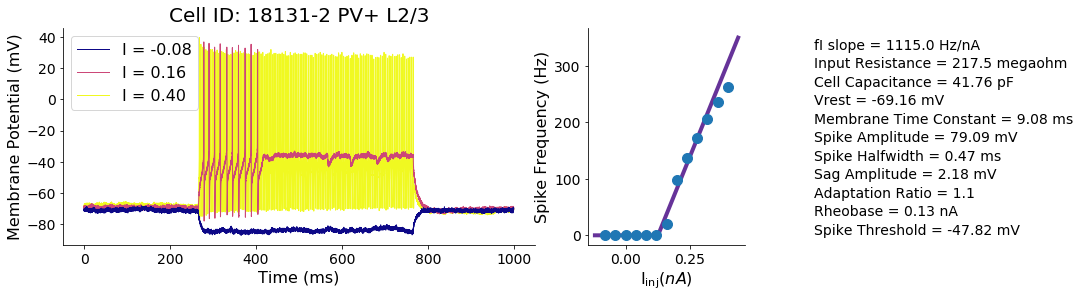

In [4]:
cells['18131-2'].ephys.plot()

## Table of electrophysiological properties and descriptive statistics

In [5]:
from ncstudy.utils import merge_dicts

In [6]:
cells.collect_results()

In [7]:
df = pd.DataFrame(data=merge_dicts(cells.metadata,cells.ephys), index=cells.keys());

# Reorder columns

cols = ['Fluorescence','Layer',                                                # Cell Type
        'Vrest (mV)','Input Resistance (megaohm)',                             # Passive Properties
        'Cell Capacitance (pF)','Membrane Time Constant (ms)',                 # Passive Properties
        'Rheobase (nA)','fI slope (Hz/nA)',                                    # Active Properties
        'Adaptation Ratio','Sag Amplitude (mV)',                               # Slow Properties
        'Spike Threshold (mV)','Spike Amplitude (mV)','Spike Halfwidth (ms)']  # Action Potential Properties

df = df[cols]
cells.df_ephys = df[df['Layer']=='L2/3']
cells.df_ephys.groupby('Fluorescence').mean().round(2)

,Vrest (mV),Input Resistance (megaohm),Cell Capacitance (pF),Membrane Time Constant (ms),Rheobase (nA),fI slope (Hz/nA),Adaptation Ratio,Sag Amplitude (mV),Spike Threshold (mV),Spike Amplitude (mV),Spike Halfwidth (ms)
Fluorescence,,,,,,,,,,,
NF,-70.40,168.90,119.32,18.53,0.10,243.63,2.09,2.87,-37.77,90.99,0.90
PV+,-70.15,145.37,67.44,9.25,0.19,918.79,1.41,3.39,-40.56,72.13,0.43
SST+,-69.95,225.95,76.58,16.41,0.05,431.38,5.67,7.76,-36.79,71.29,0.72


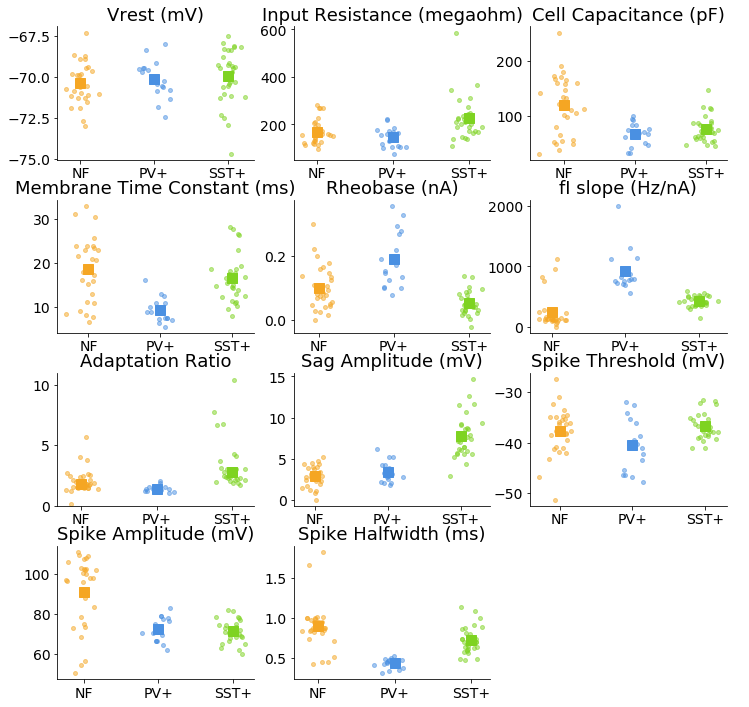

In [19]:
fig = cells.plot_ephys_summary()
fig.savefig('./figures/manuscript/ephys_features.svg')

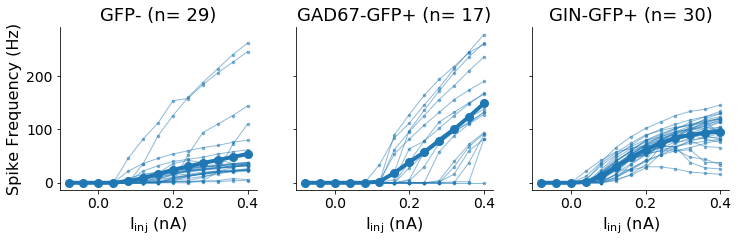

In [27]:
avFI = [[],[],[]]
fluors = ['NF','PV+','SST+']
fluors_acc = ['GFP-','GAD67-GFP+','GIN-GFP+']
I_inj = np.arange(-80,440,40)/1000. # nA

fig,axs = plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(12,3))

for cellid, celln in cells.items():
    if celln.layer == 'L2/3':
        fluor_idx = [idx for idx, fl in enumerate(fluors) if celln.fluor == fl][0]
        avFI[fluor_idx].append(celln.ephys.spikeFreq)
        plt.sca(axs[fluor_idx])
        plt.plot(I_inj, celln.ephys.spikeFreq, '.-', ms=5, lw=1, alpha=0.5, color='C0')
        
for ix, f in enumerate(avFI):
    plt.sca(axs[ix])
    plt.plot(I_inj, np.mean(f, axis=0), 'o-', ms=8, lw=4)
    plt.title(fluors_acc[ix]+ ' (n= %i)'%len(f))
    plt.xlabel('I$\mathrm{_{inj}}$ (nA)')

plt.sca(axs[0]); plt.ylabel('Spike Frequency (Hz)');
fig.savefig('./figures/manuscript/fI_curves.svg')

# Figure 2 - Optogenetic Stimulation

In [280]:
def add_inset_ax(ax,rect):
    
    '''Add an inset subplot'''
    
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    ax_inset = fig.add_axes([x,y,width,height])
    return ax_inset

def findThreshCross(trace,thresh=-20):
    return np.logical_and(trace[1:]>=thresh,trace[:-1]<thresh)

def optoResponse(t,Vss,tau_rise,tau_decay,latency):
    pre_onset = (t<latency)*V0
    onset = (t>=latency)*(t<=(50+latency))*((V0-Vss)*np.exp(-(t-latency)/tau_rise)+Vss)
    offset = (t>(50+latency))*((np.max(onset[onset!=0])-V0)*np.exp(-(t-50-latency)/tau_decay)+V0)
    response = pre_onset + onset + offset
    return response

def generalLinearDiscontinuousFn(t,*args):
    if len(args) == 2:
        slope,latency = args
        x = baseline + (t>=latency)*((t-latency)*slope)
    else:
        slopes = args[::2]
        latencies = args[1::2]
        x = baseline + (t-latencies[0])*slopes[0]*(t>=latencies[0])
        for mprev,m,l in zip(slopes[:-1],slopes[1:],latencies[1:]):
            x = x + (t-l)*(m-mprev)*(t>=l)
    return x

def aicFromRSS(RSS,n,k):
    return n*np.log(np.array(RSS)/n) + 2*k

def bicFromRSS(RSS,n,k):
    return n*np.log(np.array(RSS)/n) + k*np.log(n)

def chi2_gof(RSS_alt,RSS_null,n,dof):
    D = -n*np.log(RSS_alt/RSS_null)
    return stats.chi2.cdf(D,dof)

def fitBaselineFn(t,x):
    global baseline

    xbase = x[:15]
    tbase = t[:15]
    
    baseline = np.mean(xbase[:5])*np.ones_like(tbase)
    baselineFn = lambda t,m : generalLinearDiscontinuousFn(t,m,0)
    popt,pcov = curve_fit(baselineFn,tbase,xbase,p0=np.array([np.mean(np.diff(xbase))*10]))
    drift = baselineFn(tbase,*popt)
    
    RSSmean = len(xbase)*xbase.var()
    RSSdrift = np.sum((drift-xbase)**2)
    
    pdrift = chi2_gof(RSSdrift,RSSmean,n=len(x),dof=1)
    
    if popt[0]<=0 and pdrift > 0.95: # significant and negative drift
        baseline = np.mean(xbase[:5])*np.ones_like(t)
        baseline = baselineFn(t,*popt)
        RSSnull = np.sum((baseline-x)**2)
        dofnull = 1
    else:
        baseline = np.mean(x[:10])*np.ones_like(t)
        RSSnull = len(x)*x.var()
        dofnull = 0
    return baseline,RSSnull,dofnull

def fitGeneralLinearDiscontinuousFn(t,x):
    
    '''First need to determine appropropriate baseline'''
    
    # Fit global baseline variable
    global baseline
    baseline,RSSnull,dofnull = fitBaselineFn(t,x)
    
    maxcomps = 6
    
    p0_all = [[np.mean(np.diff(x[(i+1)*len(x)/(maxcomps+1):(i+2)*len(x)/(maxcomps+1)]))*10,
               (i+1.5)*len(x)/(10*(maxcomps+1))]
              for i in range(maxcomps)]
    p0_all = np.ravel(p0_all)
    
    bounds_lo = [0.0,0.5,0.0,2.01,-np.inf,2.01,-np.inf,2.01,-np.inf,2.01,-np.inf,2.01]
    bounds_hi = [np.inf,2.0,np.inf,t[-5],np.inf,t[-5],np.inf,t[-5],np.inf,t[-5],np.inf,t[-5]]
    
    p0_all = np.clip(p0_all,bounds_lo,bounds_hi)
    
    RSS = [RSSnull]
    
    RSSmodel = []
    
    minBIC = np.inf
    
    for ix in range(1,maxcomps+1):
        p0 = p0_all[:2*ix]
        bounds = [bounds_lo[:2*ix],bounds_hi[:2*ix]]
        try:
            popt,pcov = curve_fit(generalLinearDiscontinuousFn,t,x,p0=p0,bounds=bounds,maxfev=1000)
        except RuntimeError:
            try:
                popt,pcov = curve_fit(generalLinearDiscontinuousFn,t,x,p0=p0,bounds=bounds,maxfev=2000)
            except RuntimeError:
                try:
                    popt,pcov = curve_fit(generalLinearDiscontinuousFn,t,x,p0=p0,bounds=bounds,maxfev=5000)
                except RuntimeError:
                    try:
                        popt,pcov = curve_fit(generalLinearDiscontinuousFn,t,x,p0=p0,bounds=bounds,maxfev=10000)
                    except RuntimeError:
                        continue
        xhat = generalLinearDiscontinuousFn(t,*popt)
        RSSalt = np.sum((xhat-x)**2)
        bic = bicFromRSS(RSSalt,n=len(x),k=2*ix)
        if bic < minBIC:
            minBIC = bic
            pars = popt
            dofalt = 2*ix
        
        RSSmodel.append(RSSalt)
        
    RSSalt = min(RSSmodel)
    pmodel = chi2_gof(RSSalt,RSSnull,n=len(x),dof=dofalt-dofnull)
    
    return pars,pmodel,RSS+RSSmodel

## Example traces for 10 selected presynaptic cells with DMID targeted optogenetic stimulation

/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


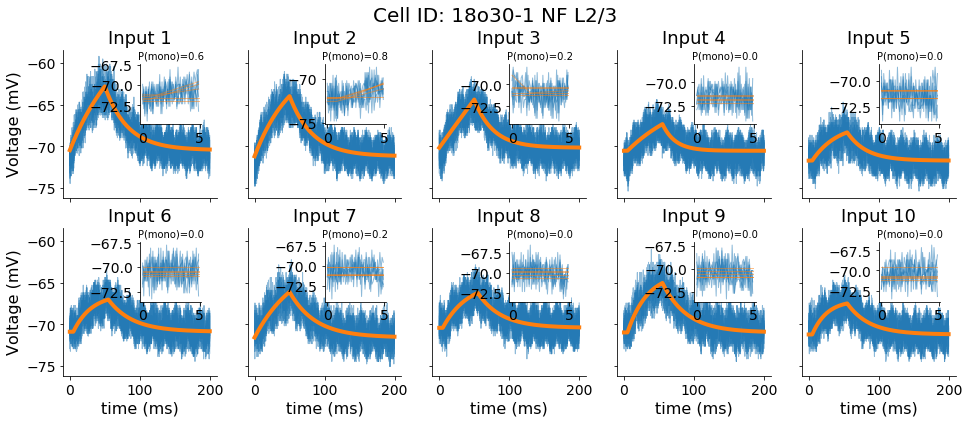

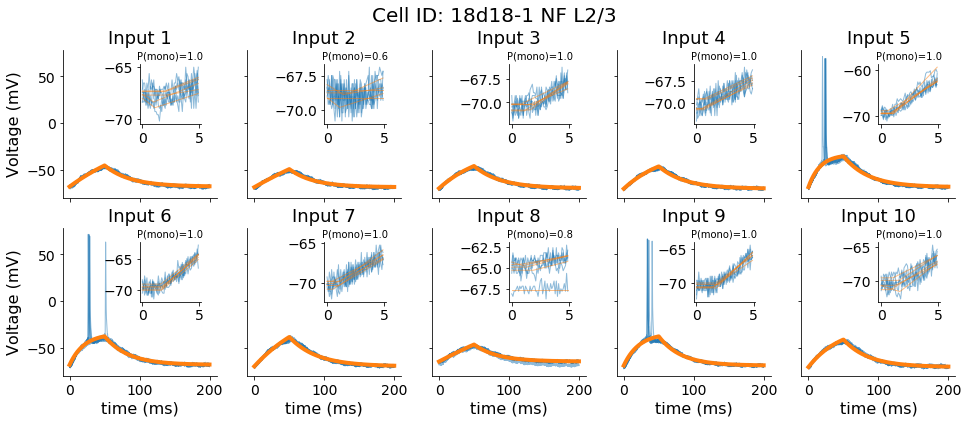

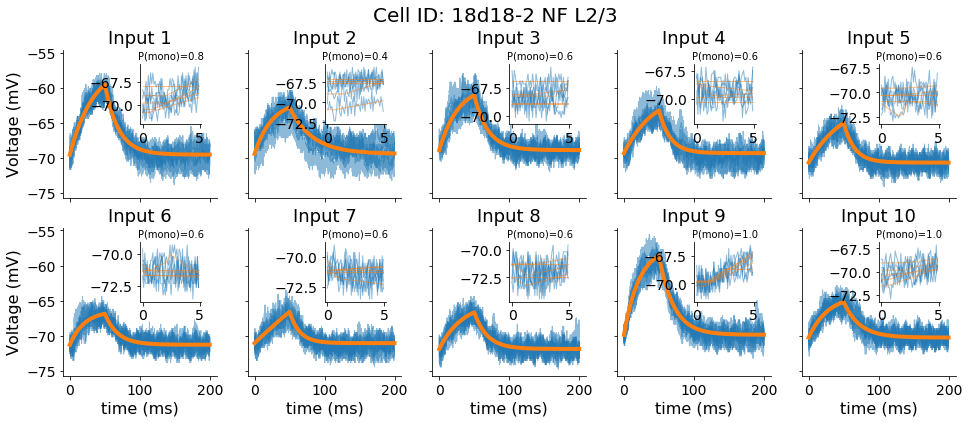

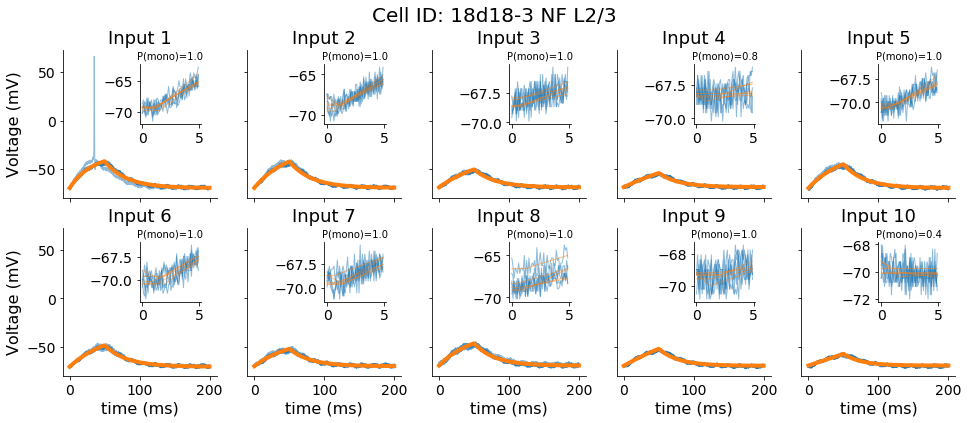

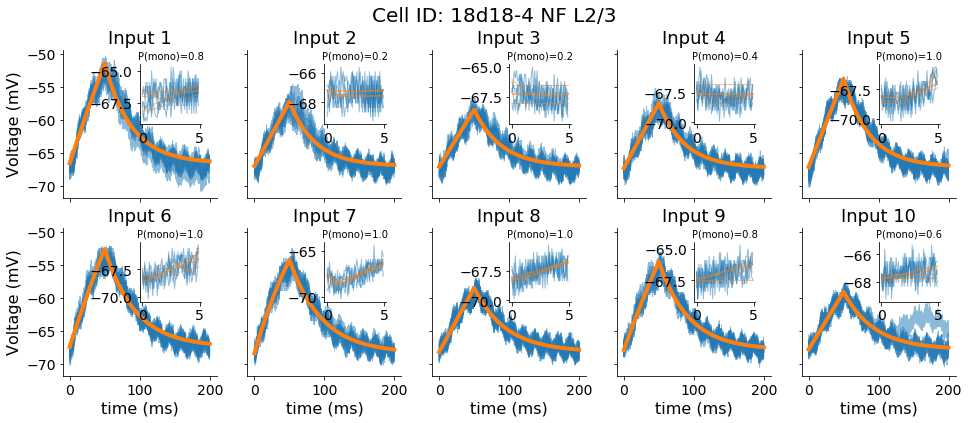

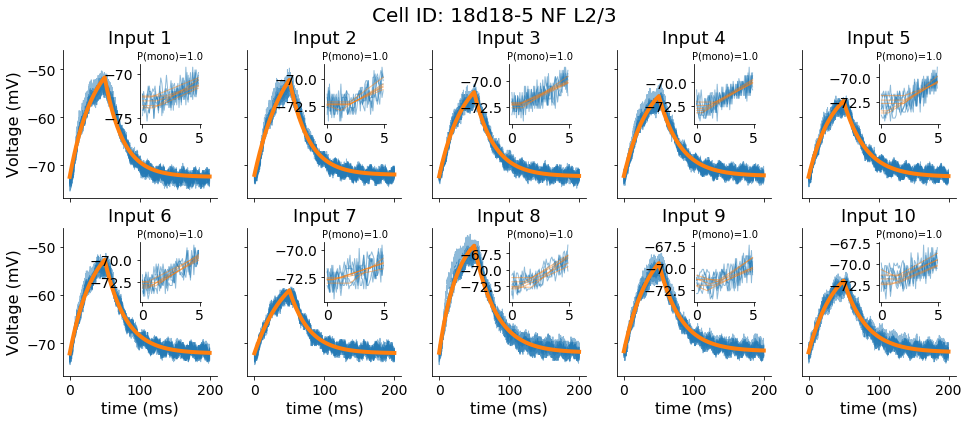

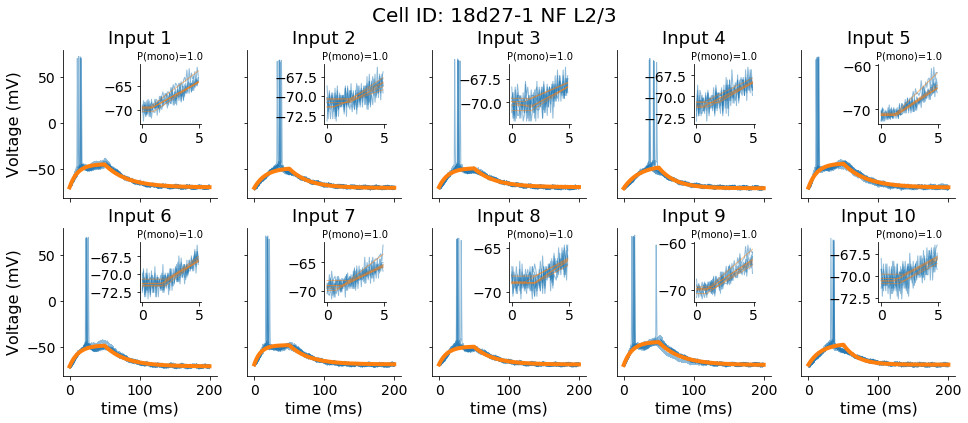

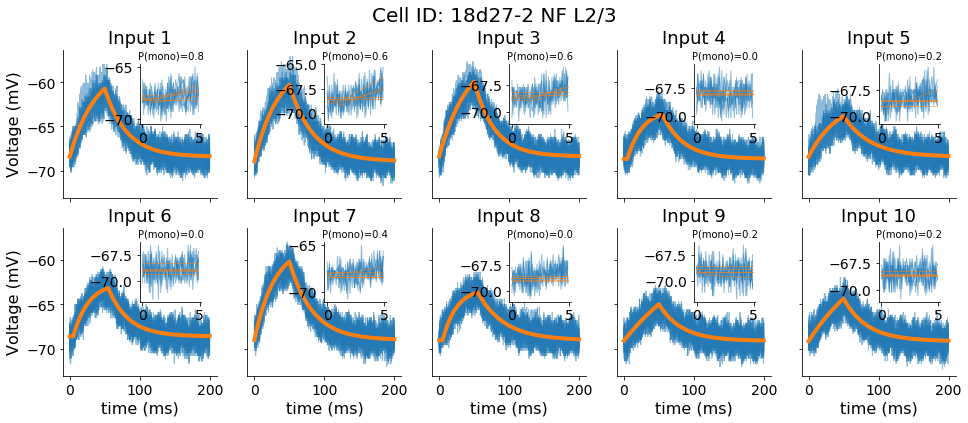

In [281]:
celldirs = []
presyn_ids = []

winsize = 50
sampling_frequency = 10000
time = np.arange(2000,dtype='float')/10

all_delays = []

with open('./stimcellids.csv','rb') as myfile:
    reader = csv.reader(myfile,delimiter=',')
    for row in reader:
        celldirs.append(row[0])
        presyn_ids.append([int(row[ii+1])-1 for ii in range(10)])
        
for celldir,presyn_id in zip(celldirs,presyn_ids):
    
    if not os.path.exists('./%s/syn_features.pkl'%(celldir)):

        try:
            data = load_episodic('./%s/Synapse_finder.abf'%(celldir))
        except IOError:
            continue

        Vm = data[0][1*sampling_frequency:6*sampling_frequency,presyn_id,0]

        pulse = data[0][1*sampling_frequency:6*sampling_frequency,:,2]
        pulse_on = np.arange(1,len(pulse))[np.logical_and(pulse[1:,0]>0.1,pulse[:-1,0]<=0.1)]

        Vm_list = [np.array([vm[p:p+2000] for p in pulse_on]) for vm in Vm.T]

        fig,axs = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(16,6))
        axs = np.ravel(axs)

        delays = []
        slopes = []
        pEarlyAP = []
        pMono = []
        meanSpikeCount = []
        stdSpikeCount = []
        taur = []
        taud = []
        Vinc = []

        for ii,traces in enumerate(Vm_list):

            '''Estimate Direct Response Properties and Spike Counts'''
            syn_delay = []
            syn_slope = []
            syn_pEarlyAP = 0.0
            syn_pMono = 0.0
            syn_spikeCount = []
            directResponseFits = []

            for trace in traces:
                pars,pmodel,RSS = fitGeneralLinearDiscontinuousFn(time[:winsize],trace[:winsize])
                syn_pEarlyAP += np.any(trace[:100]>-25)*1.0/len(traces)
                if pmodel > 0.99:
                    syn_delay.append(pars[1])
                    syn_slope.append(pars[0])
                    syn_pMono += 1./len(traces)
                    directResponseFits.append(generalLinearDiscontinuousFn(time[:winsize],*pars))
                else:
                    syn_delay.append(np.nan)
                    syn_slope.append(0.0)
                    directResponseFits.append(baseline)

                syn_spikeCount.append(np.count_nonzero(findThreshCross(trace,thresh=-25)))

            if np.any(syn_delay):
                syn_delay = np.nanmean(syn_delay)
                syn_slope = np.nanmean(syn_slope)

            delays.append(syn_delay); all_delays.append(syn_delay)
            slopes.append(syn_slope)
            pEarlyAP.append(syn_pEarlyAP)
            pMono.append(syn_pMono)
            meanSpikeCount.append(np.mean(syn_spikeCount))
            stdSpikeCount.append(np.std(syn_spikeCount,ddof=1))

            '''Estimate Network Response Properties'''
            avTrace = np.median(traces,axis=0)
            Vstart = np.mean(avTrace[:10])
            V0 = np.mean(avTrace[-50:])

            latency = syn_delay
            latency = 5.*np.isnan(syn_delay)

            optoResponse_fixdelay = lambda t,Vss,taur,taud : optoResponse(t,Vss,taur,taud,latency)

            popt,pcov = curve_fit(optoResponse_fixdelay,time,avTrace,p0=[np.percentile(trace,90),10,25])
            syn_Vss,syn_taur,syn_taud = popt
            syn_Vinc = syn_Vss - Vstart

            taur.append(syn_taur)
            taud.append(syn_taud)
            Vinc.append(syn_Vinc)

            plt.sca(axs[ii])
            plt.plot(time,traces.T,lw=1,alpha=0.5,color='C0')
            plt.title('Input %i'%(ii+1))
            if ii>4:
                plt.xlabel('time (ms)')
            if ii%5==0:
                plt.ylabel('Voltage (mV)')


            plt.plot(time,optoResponse_fixdelay(time,syn_Vss,syn_taur,syn_taud),color='C1')

            ax_inset = add_inset_ax(axs[ii],rect=[0.5,0.5,0.4,0.4])
            plt.sca(ax_inset)
            plt.plot(time[:winsize],traces[:,:winsize].T,lw=1,alpha=0.5,color='C0')
            plt.title('P(mono)=%.1f'%syn_pMono, fontsize=10)

            for rfit in directResponseFits:
                plt.plot(time[:winsize],rfit,color='C1',lw=1,alpha=0.5)


        syn_features = {'Delay (ms)':delays, 'Initial Slope (mV/ms)': slopes,                # Direct properties
                        'P(Monosynaptic)': pMono, 'P(Early AP)': pEarlyAP,                   # Direct properties
                        'Rise tau (ms)':taur, 'Decay tau (ms)': taud, 'Amplitude (mV)':Vinc, # Net properties
                        'Mean Spike Count': meanSpikeCount,'SD Spike Count': stdSpikeCount}  # Net Properties 


        '''Get Fluorescence Status and Layer of Cell'''
        with open(celldir+'/Metadata_%s.csv'%celldir,'rb') as csvfile:
            rd = csv.reader(csvfile, delimiter=',')
            md  = []
            for row in rd:
                md.append(row)
            if md[1][-1]:
                fluor,layer=md[1][1:3]

        syn_features['Fluorescence'] = fluor
        syn_features['Layer'] = layer

        f = open(celldir+'/syn_features.pkl','wb')
        pickle.dump(syn_features,f)
        f.close()

        fig.suptitle('Cell ID: %s %s %s'%(celldir,fluor,layer),fontsize=20)
        
        fig.savefig(celldir+'/syn_features.svg') # Uncomment this line if you would like to save all
    else:
        display(HTML('<img src="./%s/syn_features.svg" width=1000/>'%(celldir)))


## Table of synaptic properties and descriptive statistics

In [282]:
syn_features_all = {'Delay (ms)': [], 'Initial Slope (mV/ms)': [],                     # Direct properties
                    'P(Monosynaptic)': [], 'P(Early AP)': [],                          # Direct properties
                    'Rise tau (ms)': [], 'Decay tau (ms)': [], 'Amplitude (mV)': [],   # Net properties
                    'Mean Spike Count': [],'SD Spike Count': [],                       # Net properties
                    'Fluorescence' : [], 'Layer' : []}                                 # Cell type 
celldirs_included = []

for celldir in celldirs:
    try:
        f = open(celldir+'/syn_features.pkl','rb')
    except IOError:
        continue
    syn_features = pickle.load(f)
    f.close()
    celldirs_included.append(celldir)
    
    for key,val in syn_features.items():
        try:
            syn_features_all[key+' (%s)'%(str(val.units).split(' ')[1])].append(val.item())
        except AttributeError:
            syn_features_all[key].append(val)

df = pd.DataFrame(syn_features_all,index=celldirs_included)
cols = ['Fluorescence', 'Layer',                              # Cell Type
        'Delay (ms)', 'Initial Slope (mV/ms)',                # Direct Properties
        'P(Monosynaptic)','P(Early AP)',                      # Direct Properties
        'Rise tau (ms)','Decay tau (ms)', 'Amplitude (mV)',   # Net Properties
        'Mean Spike Count', 'SD Spike Count']                 # Net Properties

df = df[cols]

df.to_pickle('./tables/syn_features.pkl')

In [283]:
df_syn = pd.read_pickle('./tables/syn_features.pkl')

Already Analysed Cell ID: 17d05-1
Already Analysed Cell ID: 17d05-2
Already Analysed Cell ID: 17d05-3
Already Analysed Cell ID: 17d05-4
Already Analysed Cell ID: 17d06-1
Already Analysed Cell ID: 17d06-2
Already Analysed Cell ID: 17d07-1
Already Analysed Cell ID: 17d07-2
Already Analysed Cell ID: 17d11-1
Already Analysed Cell ID: 17d11-2
Already Analysed Cell ID: 17d11-3
Already Analysed Cell ID: 17d12-1
Already Analysed Cell ID: 17d13-1
Already Analysed Cell ID: 17d13-2
Already Analysed Cell ID: 17d13-3
Already Analysed Cell ID: 17n29-1
Already Analysed Cell ID: 17n29-2
Already Analysed Cell ID: 18123-1
Already Analysed Cell ID: 18131-1
Already Analysed Cell ID: 18131-2
Already Analysed Cell ID: 18201-1
Already Analysed Cell ID: 18201-2
Already Analysed Cell ID: 18202-1
Already Analysed Cell ID: 18202-2
Already Analysed Cell ID: 18202-3
Already Analysed Cell ID: 18202-4
Already Analysed Cell ID: 18302-1
Already Analysed Cell ID: 18302-2
Already Analysed Cell ID: 18302-3
Already Analys

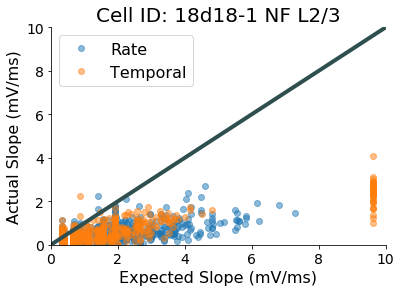

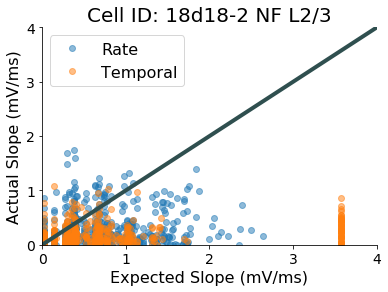

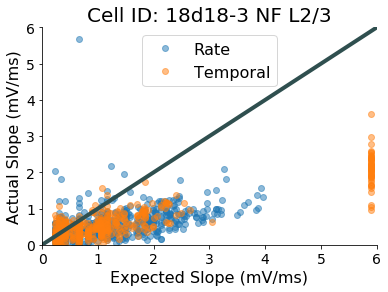

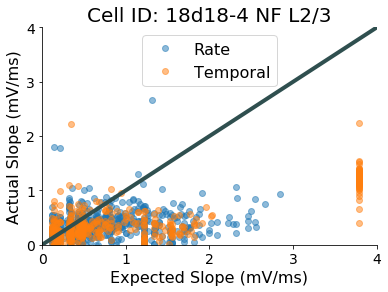

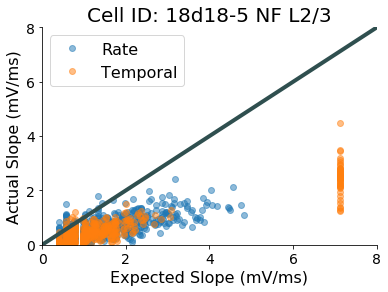

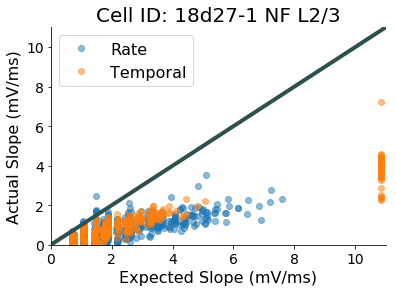

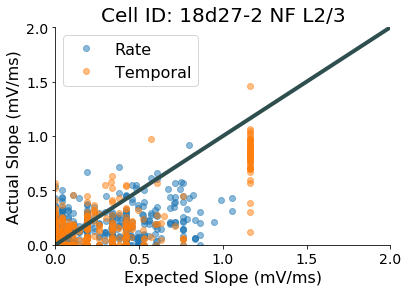

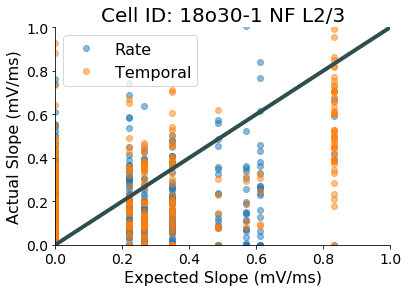

In [284]:
rateCode = np.loadtxt('./ratecode.csv',delimiter=',',skiprows=1)[:,1:]/50
tempCode = np.loadtxt('./tempcode.csv',delimiter=',',skiprows=1)[:,1:]/50
winsize=50
time = np.arange(winsize,dtype='float')/10
sampling_frequency = 10000

celldirs = [x[0][2:] for x in os.walk('./') if x[0].startswith('./1')]
celldirs.sort()

for celldir in celldirs:
    
    if os.path.isfile(celldir+'/Synapse_summation.svg'):
        
        print 'Already Analysed Cell ID: %s'%(celldir)
        
    else:
    
        print 'Analysing Cell ID: %s'%(celldir)
        
        try:
            slopes = np.array(df_syn['Initial Slope (mV/ms)'][celldir],dtype=float)
        except KeyError:
            continue

        fig = plt.figure()
        lim = np.ceil(np.nansum(slopes))
        xx = np.linspace(0,lim,1000)

        for code,fileType in zip([rateCode,tempCode],['Rate','Temporal']):

            print 'Analysing %s Code'%(fileType)

            try:
                data = load_episodic('./%s/%s.abf'%(celldir,fileType))
            except IOError:
                continue

            Vm = data[0][5*sampling_frequency:-5*sampling_frequency,:,0]

            expectedSlope = np.array([])
            actualSlope = np.array([])

            print 'Slope Fitting'

            for ix,c in enumerate(code):
                if c.any():
                    sys.stdout.write('%i %% Done \r'%(np.round(ix*100./len(code))))
                    c = c.astype('bool')
                    expectedSlope = np.append(expectedSlope,slopes[c].sum())
                    syn_slope = []
                    for trace in Vm[500*ix:500*ix+winsize].T:
                        pars,pmodel,RSS = fitGeneralLinearDiscontinuousFn(time,trace)
                        if pmodel > 0.99:
                            syn_slope.append(pars[0])
                        else:
                            syn_slope.append(0)
                    actualSlope = np.append(actualSlope,np.mean(syn_slope))

            plt.plot(expectedSlope,actualSlope,'o',alpha=0.5)

            codeSlopes = np.zeros(len(code))
            codeSlopes[code.any(axis=1)] = actualSlope

            np.savetxt('%s/%s_slopes.csv'%(celldir,fileType),codeSlopes,delimiter=',')

        plt.legend(['Rate','Temporal'])
        plt.xlim(0,lim)
        plt.ylim(0,lim) # Should hide outliers
        plt.xlabel('Expected Slope (mV/ms)')
        plt.ylabel('Actual Slope (mV/ms)')

        plt.plot(xx,xx,color='darkslategrey')

        '''Get Fluorescence Status and Layer of Cell'''
        with open(celldir+'/Metadata_%s.csv'%celldir,'rb') as csvfile:
            rd = csv.reader(csvfile, delimiter=',')
            md  = []
            for row in rd:
                md.append(row)
            if md[1][-1]:
                fluor,layer=md[1][1:3]

        plt.title('Cell ID: %s'%celldir+' %s'%fluor +' %s'%layer,fontsize=20)

        fig.savefig(celldir+'/Synapse_summation')

In [285]:
df_syn.to_pickle('./tables/syn_features.pkl')

In [216]:
sampling_frequency = 10000
time_trace = np.arange(0,50,1./sampling_frequency)
time_signal = np.arange(0, 50, 0.05)

sigBins,signal = np.loadtxt('./stim_signal.csv',delimiter=',')
signalNew = resample_signal(signal,cf=0.5,nf=20)

for celldir in celldirs:
    for fileType in ['Rate', 'Temporal']:
        if all([os.path.exists('./%s/%s_%i.svg'%(celldir, fileType, ix+1)) for ix in range(5)]):
            continue
        else:
            try:
                data = load_episodic('./%s/%s.abf'%(celldir,fileType))
            except IOError:
                continue
            
            Vm = data[0][5*sampling_frequency:-5*sampling_frequency,:,0]

            for ix in range(Vm.shape[1]):
                fig = plt.figure(figsize=(12,3))
                plt.plot(time_trace,Vm[:,ix], lw=1)
                plt.xlabel('Time (seconds)')
                plt.yticks(np.linspace(-75,75,6))
                plt.ylabel('Membrane\nPotential (mV)')
                fluor = df_syn['Fluorescence'][celldir]
                layer = df_syn['Layer'][celldir]
                plt.title('Cell ID: %s %s %s, Trace: %s %i'%(celldir, fluor, layer, fileType, ix+1))
                
                fig.subplots_adjust(top=0.8)
                axsig = fig.add_axes([0.125, 0.92, 0.775, 0.08])
                axsig.xaxis.set_visible(False)
                axsig.spines['bottom'].set_visible(False)
                plt.sca(axsig)
                plt.plot(time_signal,signalNew)
                plt.yticks([0,1],['Low', 'High'])
                plt.title('Signal', y=1.15)
                
                fig.savefig('./%s/%s_%i'%(celldir, fileType, ix+1))
                plt.close()

In [58]:
ix_rate, n_rate = np.nonzero(rateCode)
ix_temp, n_temp = np.nonzero(tempCode)

time = np.arange(0, 50, 0.05)

sigBins,signal = np.loadtxt('./stim_signal.csv',delimiter=',')
signalNew = resample_signal(signal,cf=0.5,nf=sf)

fig, (axr, axt) = plt.subplots(nrows=2, ncols=1, figsize = (12, 4), sharex=True, sharey=True)
plt.sca(axr)
plt.plot(time[ix_rate], n_rate+1, '|', ms=5)
plt.yticks([1,10])
plt.ylabel('Input #')
plt.title('Rate Code')

plt.sca(axt)
plt.plot(time[ix_temp], n_temp+1, '|', ms=5)
plt.xlabel('Time (seconds)')
plt.ylabel('Input #')
plt.title('Temporal Code')

fig.subplots_adjust(hspace=0.4, top=0.8)

axsig = fig.add_axes([0.125, 0.92, 0.775, 0.08])
axsig.xaxis.set_visible(False)
axsig.spines['bottom'].set_visible(False)
plt.sca(axsig)
plt.plot(time,signalNew)
plt.yticks([0,1],['Low', 'High'])
plt.title('Signal', y=1.15)

fig.savefig('./figures/svg/codes.svg')

NameError: name 'sf' is not defined

In [208]:
np.nonzero(rateCode)

(array([  0,   1,   1, ..., 998, 999, 999]), array([0, 2, 3, ..., 9, 3, 8]))

(array([ 13.,  17.,  17.,  34.,  82., 142., 134.,  87.,  63.,  48.]),
 array([0.5 , 0.65, 0.8 , 0.95, 1.1 , 1.25, 1.4 , 1.55, 1.7 , 1.85, 2.  ]),
 <a list of 10 Patch objects>)

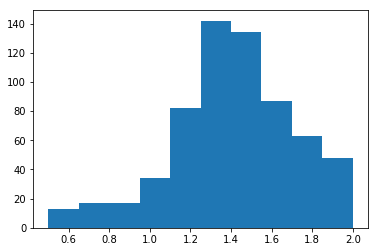

In [21]:
fig = plt.figure()
all_delays = np.concatenate(df_syn['Delay (ms)'])
all_delays = all_delays[np.isnan(all_delays)==False]
plt.hist(all_delays)

In [401]:
df_mono = df_syn[['Fluorescence', 'P(Monosynaptic)']][df_syn['Layer']=='L2/3']
df_mono['P(Monosynaptic)'] = df_mono['P(Monosynaptic)'].apply(lambda x : np.mean(x))

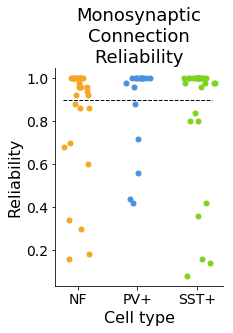

In [432]:
fluors = ['NF', 'PV+', 'SST+']
fig = plt.figure(figsize=(3,4))
colors = ['#F5A623', '#4A90E2', '#7ED321']
for ix,fl in enumerate(fluors):
    pmono = df_mono[df_mono['Fluorescence'] == fl]
    plt.plot(ix+np.random.randn(len(pmono))*0.1, pmono['P(Monosynaptic)'], '.', ms=10, color=colors[ix])
    
plt.hlines(y=0.9, xmin=-0.25, xmax=2.25, lw=1, linestyle='--')
plt.xticks(range(3), fluors)
plt.xlabel('Cell type')
plt.ylabel('Reliability')
plt.title('Monosynaptic\nConnection\nReliability')

fig.savefig('./figures/manuscript/pmono.svg')

In [433]:
df_mono

,Fluorescence,P(Monosynaptic)
17d05-1,NF,1.000000
17d05-2,NF,1.000000
17d05-4,NF,0.960000
17d06-1,PV+,1.000000
17d06-2,PV+,0.440000
17d07-1,NF,1.000000
17d13-1,PV+,1.000000
17d13-2,PV+,1.000000
17n29-2,NF,1.000000
18123-1,NF,1.000000


## Figure 3 - Mutual Information

In [434]:
def findThreshCross(trace,thresh=-20):
    return np.logical_and(trace[1:]>=thresh,trace[:-1]<thresh)

def mutualInformation(s,r):
    p_hi = np.sum(s==1)/float(len(s))
    hr = entropyEstimation(r)
    hcond = (1-p_hi)*entropyEstimation(r[s==0]) + p_hi*entropyEstimation(r[s==1])
    I = hr - hcond
    return I

def entropyEstimation(x,bins='auto'):
    px,bx = np.histogram(x,bins=bins,density=True)
    dx = np.diff(bx)
    h = -np.sum(dx*px*np.ma.log2(px))
    return h

def highestCommonFactor(x, y):
    while y != 0:
        (x, y) = (y, x % y)
    return x

hcf = highestCommonFactor

def resample_signal(x,cf,nf):
    if nf>cf:
        xtmp = np.repeat(x,np.ceil(nf/cf))
        mask = np.ones(len(xtmp),dtype=bool)
        if np.ceil(nf/cf) != nf/cf:
            skipeach = Fraction((nf/cf)/np.ceil(nf/cf)).limit_denominator().denominator
            mask[::skipeach] = 0
        xnew = xtmp[mask]
    elif nf<cf:
        xtmp = x[::int(cf/hcf(cf,nf))]
        xnew = np.repeat(xtmp,int(nf/hcf(cf,nf)))
    elif nf==cf:
        xnew = x
    return xnew

def binned_stat(x,cf,nf,T,stat='mean'):
    time = np.arange(0,T,1./cf)
    nbins = int(T*nf)
    if nbins==T*nf:
        xnew = stats.binned_statistic(time,x,statistic=stat,bins=nbins)[0]
        return xnew
    else:
        raise ValueError('Bin size is non-integer: Bin size = %.3f'%(T*nf))
        
def jointEntropyEstimation2D(x,y,bins='auto'):
    pxy,bx,by = np.histogram2d(x,y,bins=bins,normed=True)
    dx = np.diff(bx)[0]
    dy = np.diff(by)[0]
    hxy = -np.sum(dx*dy*pxy*np.ma.log2(pxy))
    return hxy

def jointEntropyEstimation3D(x,y,z,bins='auto'):
    pxyz,(bx,by,bz) = np.histogramdd([x,y,z],bins=bins,normed=True)
    dx = np.diff(bx)[0]
    dy = np.diff(by)[0]
    dz = np.diff(bz)[0]
    hxyz = -np.sum(dx*dy*dz*pxyz*np.ma.log2(pxyz))
    return hxyz

def spikeMutualInformation(postSpikes, signal, preSpikes):
    maxPostSpikes = max([max(post) for post in postSpikes])
    
    br = np.arange(-0.5,maxPostSpikes+1.5,1) # Bins for POST-synaptic spike count
    bs = np.arange(-0.5,2.5,1)  # Bins for signal state (0- low, 1-high)
    bc = np.arange(-0.5,11.5,1) # Bins for PRE-synaptic spike count
    
    prc  = []
    prc0 = []
    prc1 = []
    prs  = []
    pr   = []
    
    for nSp in postSpikes:
        prc.append(np.histogram2d(preSpikes, nSp, bins=[bc,br], normed=True)[0])
        prc0.append(np.histogram2d(preSpikes[signalNew==0],nSp[signalNew==0],
                                  bins=[bc,br],
                                  normed=True)[0])
        prc1.append(np.histogram2d(preSpikes[signalNew==1],nSp[signalNew==1],
                                  bins=[bc,br],
                                  normed=True)[0])

        prs.append(np.histogram2d(nSp,signal,bins=[br,bs],normed=True)[0])

        pr.append(np.histogram(nSp,bins=br,normed=True)[0])
        
    prc = np.array(prc).mean(axis=0)                # P(pre, post)
    prc0 = np.array(prc0).mean(axis=0)              # P(pre, post | signal = low)
    prc1 = np.array(prc1).mean(axis=0)              # P(pre, post | signal = high)

    prs = np.array(prs).mean(axis=0)                # P(post, signal)
    pr = np.array(pr).mean(axis=0)                  # P(post)

    p1 = np.sum(signalNew==1)/float(len(signalNew)) # P(signal = high)
    prsc = np.array([(1-p1)*prc0,p1*prc1])          # P(pre, post, signal)

    hrc = -np.sum(prc*np.ma.log2(prc))                               # H(pre, post)
    hsc = jointEntropyEstimation2D(signalNew,nSpikesIn,bins=[bs,bc]) # H(signal, pre)
    hrsc = -np.sum(prsc*np.ma.log2(prsc))                            # H(pre, post, signal)
    hc = entropyEstimation(nSpikesIn,bins=bc)                        # H(pre)

    mic = hrc + hsc - hrsc - hc # I(signal; post | pre) = H(post, pre) + H(signal, pre) - H(signal, post, pre) - H(pre)
    
    hrs = -np.sum(prs*np.ma.log2(prs))            # H(post, signal)
    hr = -np.sum(pr*np.ma.log2(pr))               # H(post)
    hs = -(p1*np.log2(p1) +(1-p1)*np.log2(1-p1))  # H(signal)

    mi = hr + hs - hrs                            # I(signal; post) = H(post) + H(signal) - H(post, signal)
    
    return mi, mic

def mutualInformation(s,r, respType):
    
    # respType should be 'cont' or 'spikes'
    
    if respType == 'cont':
        bins_r = np.histogram(r,bins='auto')[1]
    
    elif respType == 'spikes':
        bins_r = np.arange(-0.5, max(r)+1.5, 1)
        
    bins_s = np.arange(-0.5, max(s) + 1.5, 1)
    
    hr = entropyEstimation(r, bins=bins_r)
    hs = entropyEstimation(s, bins=bins_s)
    hrs = jointEntropyEstimation2D(r,s,bins=[bins_r, bins_s])
    
    I = hr + hs - hrs
    
    return I

def conditionalMutualInformation(r,s,c,respType):
    
    # respType should be 'cont' or 'spikes'
    
    if respType == 'cont':
        bins_r = np.histogram(r,bins='auto')[1]
    
    elif respType == 'spikes':
        bins_r = np.arange(-0.5,max(r)+1.5,1)
    
    bins_s = np.arange(-0.5,max(s)+1.5,1)
    bins_c = np.arange(-0.5,max(c)+1.5,1)
    
    hrc = jointEntropyEstimation2D(r,c,bins=[bins_r,bins_c]);
    hsc = jointEntropyEstimation2D(s,c,bins=[bins_s,bins_c]);
    hrsc = jointEntropyEstimation3D(r,s,c,bins=[bins_r,bins_s,bins_c]);
    hc = entropyEstimation(c,bins=bins_c);
    
    I = hrc + hsc - hrsc - hc
    
    return I

In [468]:
rateCode = np.loadtxt('./ratecode.csv',delimiter=',',skiprows=1)[:,1:]/50
tempCode = np.loadtxt('./tempcode.csv',delimiter=',',skiprows=1)[:,1:]/50

sigBins,signal = np.loadtxt('./stim_signal.csv',delimiter=',')
sigsf = 1/np.diff(sigBins)[0]
sampling_rate = 10000
celldirs = [x[0][2:] for x in os.walk('./') if x[0].startswith('./1')]
celldirs.sort()

sampling_freqs = [0.5,2,5,20,50,100]
spTimeWins = [0.005,0.008,0.01,0.015,0.02,0.05, 'poly_05', 'poly_10']

df_syn = pd.read_pickle('./tables/syn_features.pkl')

MI_avVm = []
MI_slope = []
MI_spike = []

MIc_avVm = []
MIc_slope = []
MIc_spike = []

for fileType,code in zip(['Rate','Temporal'],[rateCode,tempCode]):
    
    MI_avVm_type = []
    MI_slope_type = []
    MI_spike_type = []
    
    MIc_avVm_type = []
    MIc_slope_type = []
    MIc_spike_type = []
    
    fluors = []
    celldirs_included = []
    
    nSpikesIn = code.sum(axis=1)
    
    for celldir in celldirs:
        
        pmono = df_syn['P(Monosynaptic)'][celldir]
        layer = df_syn['Layer'][celldir]
        include = np.sum(pmono) >= 9.0 and layer == 'L2/3'
        print('%s Include cell %s'%(celldir, include))
        
        # Filter out fast-spiking NF cells
        
        fluor = df_ephys['Fluorescence'][celldir]
        fIslope = df_ephys['fI slope (Hz/nA)'][celldir]
        exclude_nf = fluor=='NF' and fIslope > 500
        print('%s Exclude NF %s'%(celldir, exclude_nf))
        
        if include and not exclude_nf: # 90% reliability
            
            try:
                data = load_episodic(celldir+'/%s.abf'%fileType)[0]
            except IOError:
                print 'No such file as %s/%s.abf'%(celldir,fileType)
                continue

            try:
                slopes = np.loadtxt('%s/%s_slopes.csv'%(celldir,fileType),delimiter=',')
            except IOError:
                print 'No such file as %s/%s_slopes.csv'%(celldir,fileType)
                continue

            fluors.append(df_syn['Fluorescence'][celldir])
            celldirs_included.append(celldir)
            
            Vm = data[5*sampling_rate:-5*sampling_rate,:,0]
            T = len(Vm)/sampling_rate
            time = np.arange(0,T,1./sampling_rate)
            spikeBins = np.arange(0,T+0.05,0.05)

            MI_avVm_tmp = []
            MI_slope_tmp = []
            MI_spike_tmp = []

            MIc_avVm_tmp = []
            MIc_slope_tmp = []
            MIc_spike_tmp = []

            for sf in sampling_freqs:
                signalNew = resample_signal(signal,cf=0.5,nf=sf)
                signalNew = np.tile(signalNew, Vm.shape[1])
                
                if sf<20:
                    reNSpikesIn = binned_stat(nSpikesIn,cf=20,nf=sf,T=T,stat='sum')
                elif sf>20:
                    reNSpikesIn = np.zeros((len(code)*sf/20,10))
                    for ix in range(10):
                        reNSpikesIn[(np.arange(len(code))[code[:,ix]==1]*float(sf)/20).astype('int'),ix] = 1
                    reNSpikesIn = reNSpikesIn.sum(axis=1)
                else:
                    reNSpikesIn = nSpikesIn
                
                avVm = np.array([binned_stat(x=vm,cf=sampling_rate,nf=sf,T=T,stat='mean') for vm in Vm.T])
                MI_avVm_tmp.append(mutualInformation(s = signalNew, r = np.ravel(avVm), respType='cont'))
                MIc_avVm_tmp.append(conditionalMutualInformation(r = np.ravel(avVm), s = signalNew,
                                                                 c = np.tile(reNSpikesIn, avVm.shape[0]),
                                                                 respType='cont'))
            MI_avVm_type.append(MI_avVm_tmp)
            MIc_avVm_type.append(MIc_avVm_tmp)

            threshCrosses = findThreshCross(Vm)
            spikeTimes = [time[1:][tc] for tc in threshCrosses.T]
            signalNew = resample_signal(signal,cf=0.5,nf=20)
            
            for win in spTimeWins:
                if type(win) is float:
                    spikeTimesInWin = [spT[spT%0.05<win] for spT in spikeTimes]
                elif type(win) is str:
                    win = 0.005 if win == 'poly_05' else 0.01
                    spikeTimesInWin = [spT[spT%0.05>=0.005] for spT in spikeTimes]
            
                nSpikes = [np.histogram(spT,spikeBins)[0] for spT in spikeTimesInWin]
                mi, mic = spikeMutualInformation(nSpikes, signalNew, nSpikesIn)
                MIc_spike_tmp.append(mic)
                MI_spike_tmp.append(mi)
                
            MI_spike_type.append(MI_spike_tmp)
            MIc_spike_type.append(MIc_spike_tmp)

            signalNew = resample_signal(signal,cf=0.5,nf=20)
            MI_slope_type.append(mutualInformation(s = signalNew[slopes.nonzero()], r= slopes[slopes.nonzero()],
                                                   respType = 'cont'))
            
            MIc_slope_type.append(conditionalMutualInformation(slopes[slopes.nonzero()],
                                                               signalNew[slopes.nonzero()],
                                                               nSpikesIn[slopes.nonzero()],
                                                               respType='cont'))
    MI_avVm.append(MI_avVm_type)
    MI_slope.append(MI_slope_type)
    MI_spike.append(MI_spike_type)
    
    MIc_avVm.append(MIc_avVm_type)
    MIc_slope.append(MIc_slope_type)
    MIc_spike.append(MIc_spike_type)

17d05-1 Include cell True
17d05-1 Exclude NF True
17d05-2 Include cell True
17d05-2 Exclude NF False
17d05-3 Include cell False
17d05-3 Exclude NF True
17d05-4 Include cell True
17d05-4 Exclude NF False
17d06-1 Include cell True
17d06-1 Exclude NF False
17d06-2 Include cell False
17d06-2 Exclude NF False
17d07-1 Include cell True
17d07-1 Exclude NF False
17d07-2 Include cell False
17d07-2 Exclude NF False
17d11-1 Include cell False
17d11-1 Exclude NF False
17d11-2 Include cell False
17d11-2 Exclude NF False
17d11-3 Include cell False
17d11-3 Exclude NF False
17d12-1 Include cell False
17d12-1 Exclude NF False
17d13-1 Include cell True
17d13-1 Exclude NF False
17d13-2 Include cell True
17d13-2 Exclude NF False
17d13-3 Include cell False
17d13-3 Exclude NF False
17n29-1 Include cell False
17n29-1 Exclude NF False
17n29-2 Include cell True
17n29-2 Exclude NF False
18123-1 Include cell True
18123-1 Exclude NF False
18131-1 Include cell True
18131-1 Exclude NF False
18131-2 Include cell Fal

18d27-2 Include cell False
18d27-2 Exclude NF False
18o01-1 Include cell False
18o01-1 Exclude NF False
18o01-2 Include cell True
18o01-2 Exclude NF False
18o04-1 Include cell False
18o04-1 Exclude NF False
18o04-2 Include cell True
18o04-2 Exclude NF False
18o04-3 Include cell True
18o04-3 Exclude NF False
18o04-4 Include cell False
18o04-4 Exclude NF False
18o30-1 Include cell False
18o30-1 Exclude NF False


In [469]:
np.sum(df_syn['P(Monosynaptic)']['17d11-1']) >= 9.0

True

In [470]:
MI_avVm = np.array(MI_avVm)
MI_slope = np.array(MI_slope)
MI_spike = np.array(MI_spike)

MIc_avVm = np.array(MIc_avVm)
MIc_slope = np.array(MIc_slope)
MIc_spike = np.array(MIc_spike)

In [471]:
keys_avVm_binsize = ['%i ms'%bs for bs in 1000/np.array(sampling_freqs)]
keys_spike_binsize = ['0-%i ms'%(bs*1000) for bs in spTimeWins[:-2]] + ['5-50 ms', '10-50 ms']

keys_MI = ['MI', 'MIc']
keys_data = ['Spikes', 'Slopes', 'avVm']
keys_code = ['Rate', 'Temp']

In [472]:
dict_MI_rate_avVm = dict(zip(keys_avVm_binsize, MI_avVm[0, :].T))
dict_MI_temp_avVm = dict(zip(keys_avVm_binsize, MI_avVm[1, :].T))
dict_MIc_rate_avVm = dict(zip(keys_avVm_binsize, MIc_avVm[0, :].T))
dict_MIc_temp_avVm = dict(zip(keys_avVm_binsize, MIc_avVm[1, :].T))

dict_MI_rate_spike = dict(zip(keys_spike_binsize, MI_spike[0, :].T))
dict_MI_temp_spike = dict(zip(keys_spike_binsize, MI_spike[1, :].T))
dict_MIc_rate_spike = dict(zip(keys_spike_binsize, MIc_spike[0, :].T))
dict_MIc_temp_spike = dict(zip(keys_spike_binsize, MIc_spike[1, :].T))

dict_MI_rate = dict(zip(keys_data, [dict_MI_rate_spike, MI_slope[0], dict_MI_rate_avVm]))
dict_MIc_rate = dict(zip(keys_data, [dict_MIc_rate_spike, MIc_slope[0], dict_MIc_rate_avVm]))
dict_MI_temp = dict(zip(keys_data, [dict_MI_temp_spike, MI_slope[1], dict_MI_temp_avVm]))
dict_MIc_temp = dict(zip(keys_data, [dict_MIc_temp_spike, MIc_slope[1], dict_MIc_temp_avVm]))

dict_rate = dict(zip(keys_MI, [dict_MI_rate, dict_MIc_rate]))
dict_temp = dict(zip(keys_MI, [dict_MI_temp, dict_MIc_temp]))

MI_estimates = dict(zip(keys_code, [dict_rate, dict_temp]))

In [473]:
flat_dict_keys = []
flat_dict_vals = []

for k1 in keys_code:
    for k2 in keys_MI:
        for k3 in keys_data:
            if k3 == 'Spikes':
                for k4 in keys_spike_binsize:
                    flat_dict_keys.append((k1,k2,k3,k4))
                    flat_dict_vals.append(MI_estimates[k1][k2][k3][k4])
            elif k3 == 'avVm':
                for k4 in keys_avVm_binsize:
                    flat_dict_keys.append((k1,k2,k3,k4))
                    flat_dict_vals.append(MI_estimates[k1][k2][k3][k4])
            else:
                flat_dict_keys.append((k1,k2,k3))
                flat_dict_vals.append(MI_estimates[k1][k2][k3])
                
flat_dict_keys.insert(0,('Fluorescence',))
flat_dict_vals.insert(0, fluors)
                
MI_estimates_flat = dict(zip(flat_dict_keys, flat_dict_vals))

In [474]:
df_MI = pd.DataFrame(MI_estimates_flat, index = celldirs_included)
df_MI.to_pickle('./tables/MI_calculations.pkl')

In [475]:
df_MI = pd.read_pickle('./tables/MI_calculations.pkl')

In [476]:
df_MI

Fluorescence      Rate                                          \
                 NaN        MI                                           
                 NaN    Slopes    Spikes                                 
                 NaN       NaN   0-10 ms   0-15 ms   0-20 ms    0-5 ms   
17d05-2           NF  0.027385  0.007516  0.036793  0.053852  0.000000   
17d05-4           NF  0.043303  0.002635  0.023527  0.093987  0.000636   
17d06-1          PV+  0.045901  0.005777  0.014721  0.064832  0.000000   
17d07-1           NF  0.022350  0.005314  0.055943  0.132666  0.000000   
17d13-1          PV+  0.062953  0.324662  0.350366  0.376200  0.179728   
17d13-2          PV+  0.047929  0.003675  0.004523  0.005500  0.000000   
17n29-2           NF  0.043597  0.024846  0.045011  0.093778  0.009165   
18123-1           NF  0.029011  0.008594  0.039373  0.074677  0.000636   
18131-1          PV+  0.435643  0.007023  0.013684  0.026858  0.002971   
18201-2           NF  0.031019  0.000000  0.000189  0.000042  0.000000   
18202-1          PV+  0.049722  0.001272  0.000351  0.000351  0.000000   
18202-2          PV+  0.018361  0.285288  0.288879  0.292407  0.118134   
18202-3          PV+  0.026760  0.060745  0.069341  0.077427  0.015576   
18202-4          PV+  0.055503  0.044815  0.045131  0.065345  0.002333   
18302-1         SST+  0.042021  0.072234  0.085160  0.137195  0.001060   
18302-2         SST+  0.039090  0.020576  0.026060  0.061644  0.000212   
18303-1         SST+  0.050209  0.110867  0.143606  0.185264  0.001847   
18307-2         SST+  0.026322  0.170607  0.235006  0.257791  0.008852   
18308-1         SST+  0.047556  0.078970  0.171564  0.199905  0.001060   
18319-1         SST+  0.024711  0.187373  0.240868  0.323190  0.079248   
18319-2         SST+  0.033688  0.005954  0.061532  0.136683  0.000000   
18320-1         SST+  0.033668  0.063451  0.143710  0.201871  0.000314   
18321-1         SST+  0.030310  0.009400  0.031448  0.078710  0.000000   
18321-2         SST+  0.045672  0.070410  0.181459  0.237215  0.000000   
18327-1         SST+  0.060509  0.177400  0.214868  0.226309  0.012128   
18327-2         SST+  0.045247  0.144233  0.187048  0.242451  0.025140   
18328-3         SST+  0.068672  0.010023  0.094617  0.193444  0.000424   
18402-1         SST+  0.068119  0.186535  0.237690  0.256976  0.012390   
18402-3         SST+  0.056313  0.159509  0.254476  0.335730  0.013245   
18404-1         SST+  0.038300  0.241131  0.303841  0.328602  0.053150   
18412-1           NF  0.051600  0.000000  0.000000  0.000000  0.000000   
18412-2           NF  0.026941  0.003077  0.010233  0.042616  0.000000   
18412-3          PV+  0.020802  0.037162  0.201598  0.271134  0.001909   
18418-1          PV+  0.057130  0.264260  0.325950  0.355053  0.125828   
18518-1         SST+  0.064463  0.061226  0.150968  0.204511  0.001484   
18518-2         SST+  0.040446  0.000636  0.022808  0.097341  0.000000   
18518-3         SST+  0.040711  0.050161  0.107119  0.181251  0.000424   
18518-4         SST+  0.031839  0.075182  0.118107  0.176885  0.004278   
18529-1           NF  0.031520  0.015845  0.102026  0.162035  0.000000   
18531-1         SST+  0.033527  0.129440  0.174660  0.201160  0.004035   
18531-3         SST+  0.017874  0.100479  0.223018  0.270755  0.001528   
18601-2           NF  0.052818  0.001783  0.003313  0.036598  0.000636   
18914-2           NF  0.022717  0.002121  0.021800  0.069939  0.000000   
18d18-1           NF  0.035987  0.002333  0.013745  0.048412  0.000212   
18d18-3           NF  0.024634  0.002706  0.014343  0.029667  0.000424   
18d18-5           NF  0.038633  0.000000  0.001060  0.009165  0.000000   
18d27-1           NF  0.020924  0.034360  0.101902  0.162272  0.000212   
18o01-2           NF  0.037167  0.005467  0.037768  0.058485  0.000212   
18o04-2          PV+  0.023884  0.129065  0.225118  0.264104  0.005527   
18o04-3          PV+  0.030357  0.123977  0.140550  0.160533  0.019713   

           

In [477]:
df_MI['Fluorescence', np.nan, np.nan, np.nan].value_counts()

SST+    22
NF      16
PV+     12
Name: (Fluorescence, nan, nan, nan), dtype: int64

## Bar Charts for Matt 

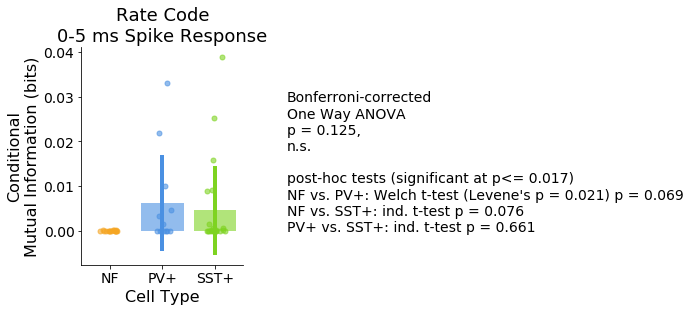

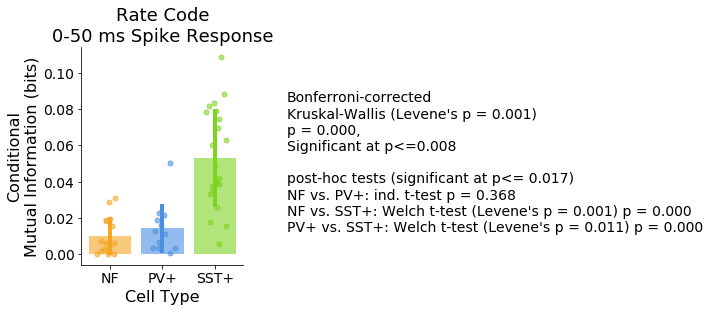

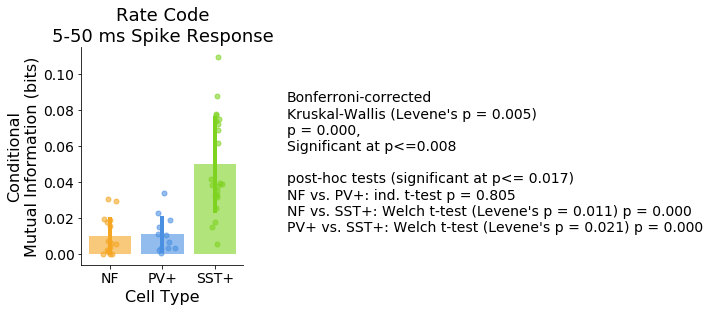

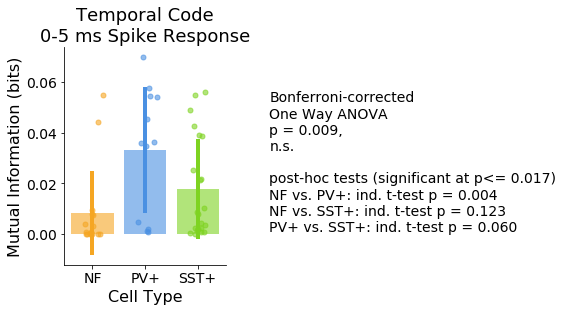

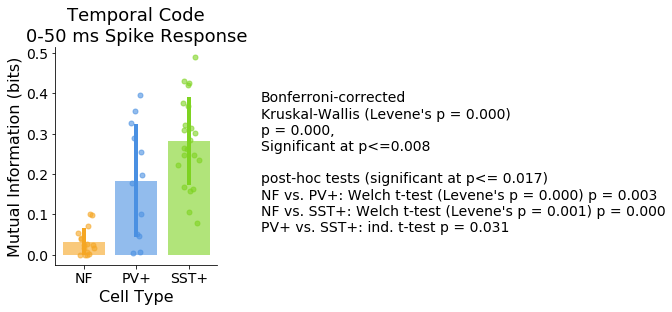

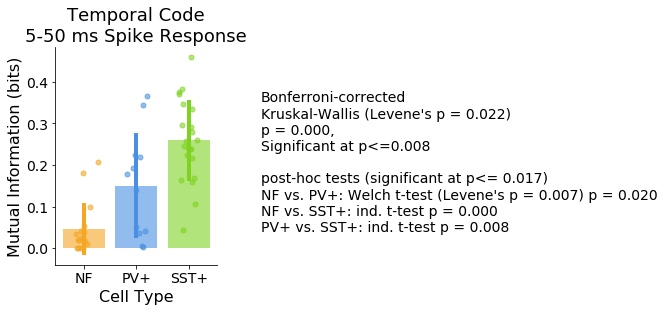

In [478]:
df_cols = [('Rate', 'MIc', 'Spikes', '0-5 ms'),
          ('Rate', 'MIc', 'Spikes', '0-50 ms'),
          ('Rate', 'MIc', 'Spikes', '5-50 ms'),
          ('Temp', 'MI', 'Spikes', '0-5 ms'),
          ('Temp', 'MI', 'Spikes', '0-50 ms'),
          ('Temp', 'MI', 'Spikes', '5-50 ms')
          ]

df_grouping = [('Fluorescence',np.nan,np.nan,np.nan)]

fluor_group_keys = ['NF', 'PV+', 'SST+']
fluor_group_pairs = list(combinations(range(len(fluor_group_keys)), 2))

colors = ['#F5A623', '#4A90E2', '#7ED321']

width = 0.8
alpha = 0.6
spread = 0.1

for col in df_cols:
    
    '''Figures'''
    
    df_bars = df_MI[df_grouping + [col]]
    df_bars_grouped = df_bars.groupby(df_grouping)
    means = df_bars_grouped.mean()
    stds = df_bars_grouped.std()
    
    conds_title = ('Temporal' if 'Temp' in col else 'Rate',
                   'V$_m$' if 'avVm' in col else col[-1] + ' Spike' if 'Spikes' in col else 'Slopes')
    
    conds_save = ('Temporal' if 'Temp' in col else 'Rate',
                   'avVm' if 'avVm' in col else col[-1] + 'Spike' if 'Spikes' in col else 'Slopes')
                 
    
    fig = plt.figure(figsize=(6,4))
    plt.bar(np.arange(3), means[col], yerr= stds[col], width=width, alpha = alpha, color = colors, ecolor = colors)

    for ix,fl in enumerate(fluor_group_keys):
        vals = df_bars_grouped.get_group(fl)[col]
        spread_vals = np.ones_like(vals)*ix + np.random.randn(len(vals))*spread
        plt.plot(spread_vals, vals, '.', color=colors[ix], ms = 10, zorder = -2, alpha=0.6)
    plt.xticks(range(3),fluor_group_keys)
    plt.xlabel('Cell Type')
    plt.ylabel('%sMutual Information (bits)'%('Conditional\n' if 'MIc' in col else ''))
    title_string = '%s Code\n%s Response'%conds_title

    plt.title(title_string)
    
    '''Stats'''
    
    grouped_data = [df_bars.groupby(df_grouping).get_group(fl)[col] for fl in fluor_group_keys]
    _,p_levene = stats.levene(*grouped_data) # equal variances test
    
    test,test_string = (stats.f_oneway, 'One Way ANOVA') if p_levene > 0.05 else (stats.kruskal, 'Kruskal-Wallis (Levene\'s p = %.3f)'%p_levene)
    
    F, p_test = test(*grouped_data)
    
    result = 'Bonferroni-corrected\n%s\n'%test_string
    result += 'p = %.3f,\n%s\n\n'%(p_test, 'Significant at p<=%.3f'%(0.05/len(df_cols)) if p_test<=0.05/len(df_cols) else 'n.s.')
    result += 'post-hoc tests (significant at p<= %.3f)'%(0.05/len(fluor_group_pairs) )
    
    for pair in fluor_group_pairs:
        fl1 = pair[0]
        fl2 = pair[1]
        _, p_levene = stats.levene(grouped_data[fl1],grouped_data[fl2])
        test_string = 'ind. t-test' if p_levene > 0.05 else  'Welch t-test (Levene\'s p = %.3f)'%p_levene

        tstat, p_ttind = stats.ttest_ind(a = grouped_data[fl1], b = grouped_data[fl2], equal_var=p_levene>0.05)
        result += '\n%s vs. %s: %s p = %.3f'%(fluor_group_keys[fl1], fluor_group_keys[fl2], test_string, p_ttind)
    
    fig.subplots_adjust(right=0.5)
    ax_results = fig.add_axes([0.6,0.125,0.375,0.775])
    plt.sca(ax_results)
    plt.text(x=0.0, y=0.15, s=result, fontsize=14)
    plt.axis('off')
    
    fig.savefig('./figures/manuscript/MI_%s_%s_'%conds_save+'.svg')

In [479]:
df_MI.loc['18d27-1']['Temp','MI', 'Spikes']

0-10 ms     0.00273225
0-15 ms      0.0281699
0-20 ms      0.0786501
0-5 ms       0.0441105
0-50 ms       0.101983
0-8 ms       0.0268966
10-50 ms      0.180527
5-50 ms       0.180527
Name: 18d27-1, dtype: object

### Extreme example traces

In [144]:
'''Extreme MI traces'''

minMI_celldirs = np.array(df_bars.groupby(df_grouping).idxmin())
maxMI_celldirs = np.array(df_bars.groupby(df_grouping).idxmax())

for ii,fl in enumerate(fluor_group_keys):
    for jj,col in enumerate(df_cols):
        min_celldir = minMI_celldirs[ii,jj]
        max_celldir = maxMI_celldirs[ii,jj]
        newdir = './figures/FENS_poster/extreme_MI/'

        fileType = col[0] if col[0] is 'Rate' else 'Temporal'
        respType = col[2]
        
        min_filename = './%s/%s_1.svg'%(min_celldir,fileType)
        min_newfilename = '%s%s_example_%s_%s_lowMI.svg'%(newdir, fl,fileType, respType)
        
        max_filename = './%s/%s_1.svg'%(max_celldir,fileType)
        max_newfilename = '%s%s_example_%s_%s_highMI.svg'%(newdir, fl,fileType, respType)
        
        os.system('cp %s %s'%(min_filename, newdir))
        os.system('mv %s%s_1.svg %s'%(newdir,fileType,min_newfilename))
        
        os.system('cp %s %s'%(max_filename, newdir))
        os.system('mv %s%s_1.svg %s'%(newdir,fileType,max_newfilename))

IndexError: index 1 is out of bounds for axis 1 with size 1

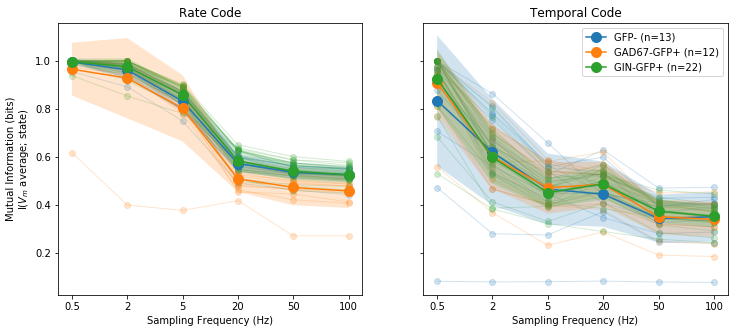

In [145]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True,sharey=True)
for MItype,ax,title in zip(MI_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for fluorLabel,fluorType,color in zip(['GFP-','GAD67-GFP+','GIN-GFP+'],['NF','PV+','SST+'],['C0','C1','C2']):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorType])
        plt.plot(MI_bycell.T,'-o',color=color,zorder=-2,lw=1,alpha=0.2)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.fill_between(range(6),avMI+sdMI,avMI-sdMI,alpha=0.2)
        plt.plot(range(6),avMI,'-o',ms=10,label=fluorLabel+' (n=%i)'%len(MI_bycell))
        
    plt.title(title)
    plt.xticks(range(6),sampling_freqs)
    plt.xlabel('Sampling Frequency (Hz)')

plt.legend()
plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI($V_m$ average; state)')

fig.savefig('./figures/svg/MI_avVm'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

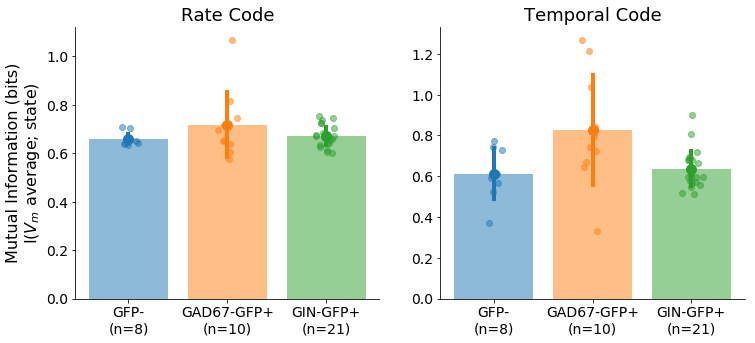

In [370]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 20

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(sampling_freqs)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI($V_m$ average; state)')
fig.savefig('./figures/svg/MI_avVm_bar.svg')

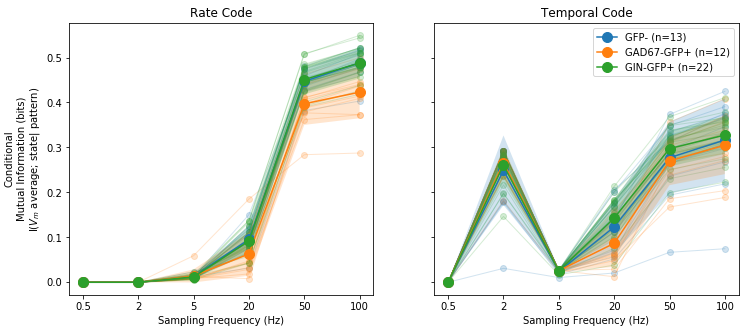

In [124]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True,sharey=True)
for MItype,ax,title in zip(MIc_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for fluorLabel,fluorType,color in zip(['GFP-','GAD67-GFP+','GIN-GFP+'],['NF','PV+','SST+'],['C0','C1','C2']):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorType])
        plt.plot(MI_bycell.T,'-o',color=color,zorder=-2,lw=1,alpha=0.2)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.fill_between(range(6),avMI+sdMI,avMI-sdMI,alpha=0.2)
        plt.plot(range(6),avMI,'-o',ms=10,label=fluorLabel+' (n=%i)'%len(MI_bycell))
        
    plt.title(title)
    plt.xticks(range(6),sampling_freqs)
    plt.xlabel('Sampling Frequency (Hz)')

plt.legend()
plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ average; state| pattern)')

fig.savefig('./figures/svg/MIc_avVm')

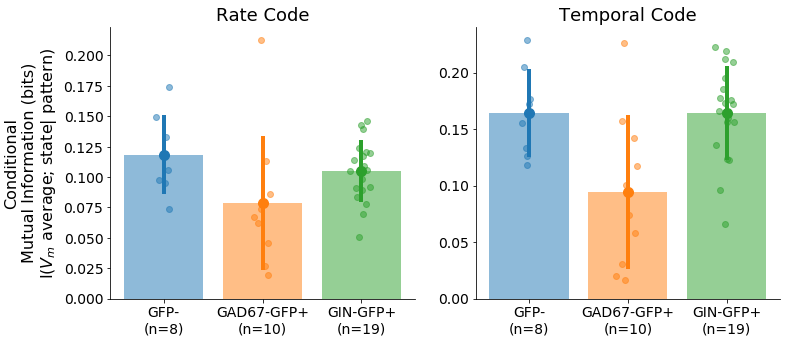

In [165]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 20

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(sampling_freqs)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ average; state| pattern)')
fig.savefig('./figures/svg/MIc_avVm_bar.svg')

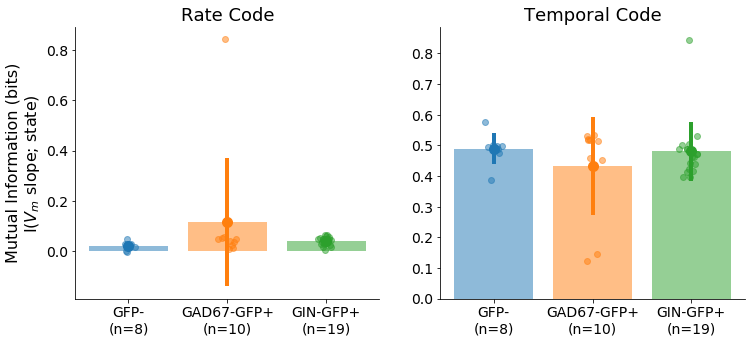

In [117]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_slope,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI($V_m$ slope; state)')
fig.savefig('./figures/svg/MI_slopes.svg')

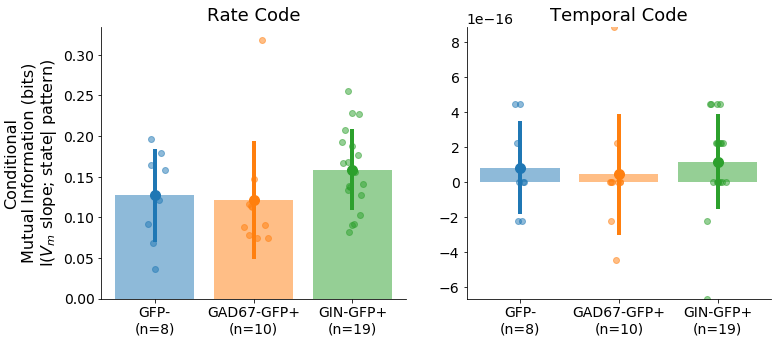

In [167]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_slope,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ slope; state| pattern)')
fig.savefig('./figures/svg/MIc_slopes.svg')

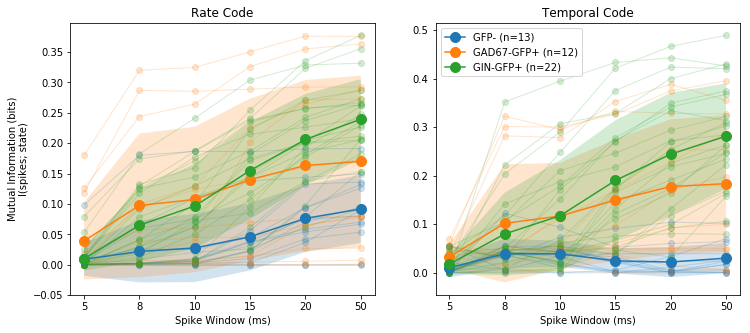

In [146]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

sptw = [int(win*1000) for win in spTimeWins]

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        avMI = np.nanmean(MI_bycell,axis=0)
        sdMI = np.nanstd(MI_bycell,axis=0,ddof=1)
        plt.plot(range(len(spTimeWins)),avMI,'-o',ms=10,label=fluorLabels[ix]+' (n=%i)'%len(MI_bycell))
        plt.fill_between(range(len(spTimeWins)),avMI+sdMI,avMI-sdMI,alpha=0.2,zorder=-2)
        plt.plot(range(len(spTimeWins)),MI_bycell.T,'-o',color=colors[ix],alpha=0.2,lw=1,zorder=-1)
    plt.title(title)
    plt.xlabel('Spike Window (ms)')
        
plt.xticks(range(len(sptw)),sptw)
plt.legend()

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI(spikes; state)')

fig.savefig('./figures/svg/MI_spikes'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

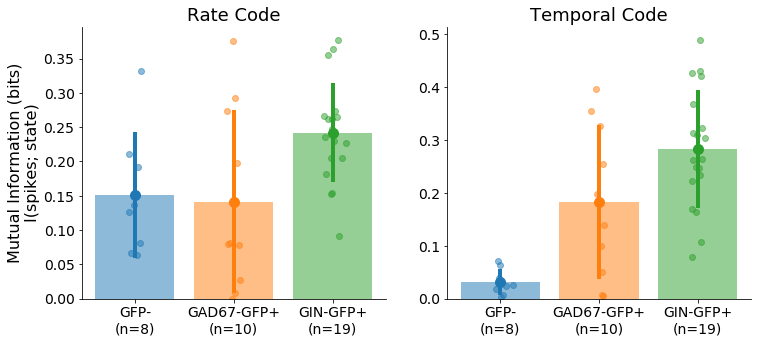

In [168]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 0.05

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(spTimeWins)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI(spikes; state)')
fig.savefig('./figures/svg/MI_spikes_bar.svg')

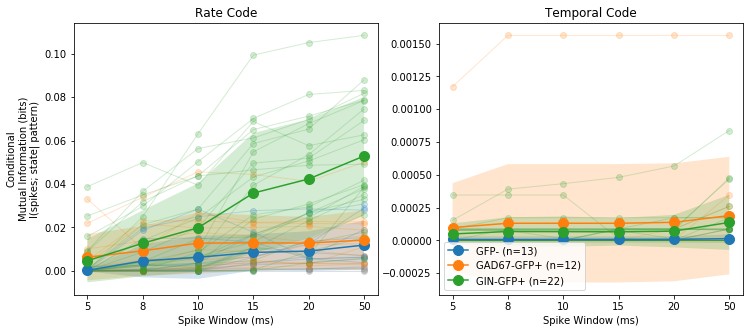

In [148]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

sptw = [int(win*1000) for win in spTimeWins]

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        avMI = np.nanmean(MI_bycell,axis=0)
        sdMI = np.nanstd(MI_bycell,axis=0,ddof=1)
        plt.plot(range(len(spTimeWins)),avMI,'-o',ms=10,label=fluorLabels[ix]+' (n=%i)'%len(MI_bycell))
        plt.fill_between(range(len(spTimeWins)),avMI+sdMI,avMI-sdMI,alpha=0.2,zorder=-2)
        plt.plot(range(len(spTimeWins)),MI_bycell.T,'-o',color=colors[ix],alpha=0.2,lw=1,zorder=-1)
    plt.title(title)
    plt.xlabel('Spike Window (ms)')
        
plt.xticks(range(len(sptw)),sptw)
plt.legend()

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI(spikes; state| pattern)')

fig.savefig('./figures/svg/MIc_spikes'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

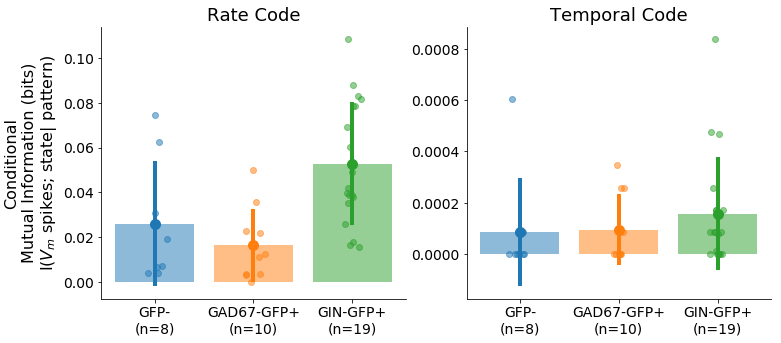

In [208]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 0.05

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(spTimeWins)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ spikes; state| pattern)')
fig.savefig('./figures/svg/MIc_spikes_bar.svg')

In [151]:
def plot_fullJointProb(pxyz,fileType,celldir,win):

    fig,axs = plt.subplots(ncols=2,figsize=(9,10),sharex=True,sharey=True)
    
    pxy0,pxy1 = pxyz

    srtp = np.ravel(pxyz)
    srtp = np.sort(srtp)
    vmax = (srtp[-3]+0.05).round(2)

    plt.sca(axs[0])
    plt.imshow(pxy0,vmin=0,vmax=vmax)
    plt.title('Low')
    plt.ylabel('Input Spike Count (Pattern)')
    plt.xlabel('Output Spike Count (Response)')

    plt.sca(axs[1])
    plt.title('High')
    plt.xlabel('Output Spike Count (Response)')
    im = plt.imshow(pxy1,vmin=0,vmax=vmax)

    plt.xlim((-0.5,5.5))
    plt.ylim((-0.5,10.5))
    plt.xticks(range(6))

    fig.text(x=0.5,y=0.975,s='%s Code (State)'%fileType,fontsize=20,horizontalalignment='center')

    fig.subplots_adjust(bottom=0.3)
    cax = fig.add_axes([0.125,0.1,0.775,0.05])

    fig.colorbar(mappable=im,cax=cax,orientation='horizontal',extend='max')
    cax.set_xlabel('P (state, pattern, response)')
    
    fig.savefig('%s/%s_joint_spikes_%i'%(celldir,fileType,int(win*1000)))
    plt.close()

In [122]:
plot_fullJointProb(prsc,fileType=fileType)

TypeError: plot_fullJointProb() takes exactly 4 arguments (2 given)

## 4. Power Spectrum

In [4]:
sampling_frequency = 10000

celldirs = [x[0][2:] for x in os.walk('./') if x[0].startswith('./1')]
celldirs.sort()

ff_rsq = []
rc_rsq = []
tc_rsq = []

ff_logp = []
rc_logp = []
tc_logp = []

for celldir in celldirs:
    try:
        data_ff = load_episodic('./%s/Full_field.abf'%celldir)
        data_rc = load_episodic('./%s/Rate.abf'%celldir)
        data_tc = load_episodic('./%s/Temporal.abf'%celldir)
    except IOError:
        continue

    Vm_ff = data_ff[0][6*sampling_frequency:-6*sampling_frequency,:,0]
    Vm_rc = data_rc[0][6*sampling_frequency:-6*sampling_frequency,:,0]
    Vm_tc = data_tc[0][6*sampling_frequency:-6*sampling_frequency,:,0]

    for Vm,rsq, all_logp in zip([Vm_ff, Vm_rc, Vm_tc],[ff_rsq, rc_rsq, tc_rsq], [ff_logp, rc_logp, tc_logp]):
        f,p = sig.periodogram(Vm.T,fs=sampling_frequency)
        p = p.mean(axis=0)
        logf = np.log10(f[f<200][1:])
        logp = np.log10(p[f<200][1:])
        all_logp.append(logp)
        slope, intercept, rval, pval, stderr = stats.linregress(logf, logp)
        rsq.append(rval**2)
        
Rsq = np.array([ff_rsq, rc_rsq, tc_rsq])

ff_logp = np.mean(ff_logp, axis=0)
rc_logp = np.mean(rc_logp, axis=0)
tc_logp = np.mean(tc_logp, axis=0)

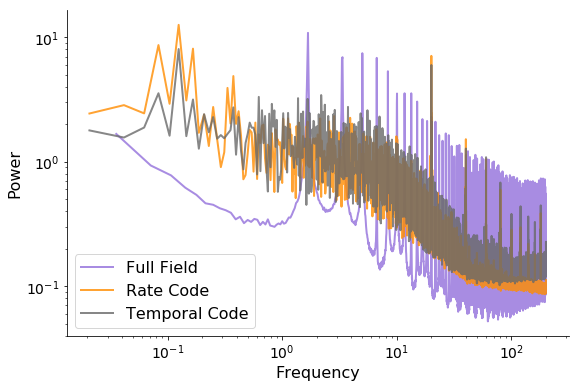

In [33]:
colors = ['mediumpurple', 'darkorange', 'dimgrey']

fig = plt.figure(figsize=(9,6))

ff_f = np.linspace(0,200,len(ff_logp)+1)[1:]
rc_f = np.linspace(0,200,len(rc_logp)+1)[1:]
tc_f = np.linspace(0,200,len(rc_logp)+1)[1:]

plt.loglog(ff_f, np.exp(ff_logp), colors[0], alpha=0.8, lw=2)
plt.loglog(rc_f, np.exp(rc_logp), colors[1], alpha=0.8, lw=2)
plt.loglog(tc_f, np.exp(tc_logp), colors[2], alpha=0.8, lw=2)

plt.legend(['Full Field', 'Rate Code', 'Temporal Code'])
plt.xlabel('Frequency')
plt.ylabel('Power')

fig.savefig('./figures/FENS_poster/power_spectrum_opto')

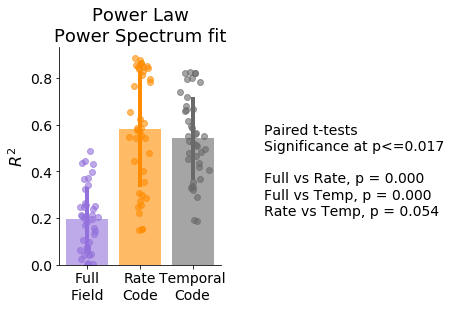

In [35]:
colors = ['mediumpurple', 'darkorange', 'dimgrey']

fig = plt.figure(figsize=(6,4))
plt.bar(range(3), Rsq.mean(axis=1), yerr=Rsq.std(axis=1, ddof=1), color=colors, alpha=0.6, ecolor=colors)
for ix,group in enumerate(Rsq):
    plt.plot(np.random.randn(len(group))*0.1+ix, group, 'o',alpha=0.6,zorder=-2, color= colors[ix])

pair_combos = list(combinations(range(3),2))
results_string = 'Paired t-tests\nSignificance at p<=%.3f\n\n'%(0.05/len(pair_combos))
dataTypes = ['Full\nField', 'Rate\nCode', 'Temporal\nCode']

for pair in pair_combos:
    ix1,ix2 = pair
    _,p_test = stats.ttest_rel(Rsq[ix1],Rsq[ix2])
    results_string += '%s vs %s, p = %.3f\n'%(dataTypes[ix1][:4], dataTypes[ix2][:4], p_test)
    
plt.xticks(range(3),dataTypes)
plt.ylabel('$R^2$')
plt.title('Power Law\nPower Spectrum fit')

fig.subplots_adjust(right=0.5)
ax_results = fig.add_axes([0.6,0.125,0.375,0.775])
plt.sca(ax_results)
plt.text(x=0.0, y=0.15, s=results_string, fontsize=14)
plt.axis('off')

fig.savefig('./figures/svg/power_spectrum_rsq')